# Overview

This notebook contains code which takes the NYPD 2012-2017 Motor Vehicle Collision data and mashes it against the NOAA daily weather files for the NYC area. Both datasets are sourced from Google BigQuery public data sets found here https://cloud.google.com/bigquery/public-data/nypd-mv-collisions.

The NYPD data was not in a clean state. Futher manupliations and joins had to be done before the two data sets could be combined. Ultimately, we look at which types of accidents are most influenced by weather or the weekend.

In [1]:
from bigquery import get_client
from time import sleep

import pandas as pd
import numpy as np

import io, os, pickle, math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bq_query_noaa = """
    #stanardSQL
    SELECT
        *
    FROM
        `jbencina-144002.nypd_traffic.noaa_2012_2017`
        
"""

bq_query_nypd = """
    #standardSQL
    SELECT
      reason,
      year,
      hour,
      month,
      day,
      dow,
      count(*) incidents
    FROM
        (SELECT 
            contributing_factor_vehicle_1 as reason,
            EXTRACT(YEAR FROM timestamp) as year,
            EXTRACT(MONTH FROM timestamp) as month,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAY FROM timestamp) as day,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow
          FROM 
            `bigquery-public-data.new_york.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")) q
    GROUP BY
      reason,
      year,
      hour,
      month,
      day,
      dow
"""

bq_query_nypd_2 = """
    #standardSQL
    SELECT
        hour,
        dow,
        sum(1) incidents,
        count(distinct date) as days
    FROM
        (SELECT 
            CAST(timestamp as DATE) as date,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow,
            1 as cnt
          FROM 
            `bigquery-public-data.new_york.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")
            AND EXTRACT(YEAR FROM timestamp)<=2015
            ) q
    GROUP BY
        hour, 
        dow

"""

def get_bq_data(query, file_out):
    # Download the .json key from your Google Cloud account
    client = get_client(json_key_file='C:/Users/jbenc/Documents/bq-query.json', readonly=True)

    job_id, _results = client.query(query, use_legacy_sql=False)
    complete = False

    while not complete==True:
        print('Checking for job {JOB}...'.format(JOB=job_id))
        complete, row_count = client.check_job(job_id)
        sleep(1)

    print('Job complete - downloading...')
    results = client.get_query_rows(job_id)
    print('Downloaded {N} results...'.format(N=len(results)))
    
    with open(file_out, 'wb') as f:
        pickle.dump(results, f)
    return results
        
def get_data(query, file_out):
    if os.path.exists(file_out):
        print('Reading downloaded file...')
        with open(file_out, 'rb') as f:
            d = pickle.load(f)
        return pd.DataFrame.from_dict(d)
    else:
        print('Downloading from BQ...')
        d = get_bq_data(query, file_out)
        return pd.DataFrame.from_dict(d)

In [3]:
results_noaa = get_data(bq_query_noaa, 'bq_noaa.p')
results_noaa.head()

Checking for job job_qiKxkK5MC62eudGELexQFc4aIMs...
Checking for job job_qiKxkK5MC62eudGELexQFc4aIMs...
Checking for job job_qiKxkK5MC62eudGELexQFc4aIMs...
Job complete - downloading...
Downloaded 32628 results...


,date,day,dow,element,id,month,name,time,value,year
0,2012-10-19,19,6,PRCP,US1NYQN0002,10,"""MIDDLE VILLAGE 0.5 SW""",None,86.0,2012
1,2012-11-07,7,4,PRCP,US1NYQN0002,11,"""MIDDLE VILLAGE 0.5 SW""",None,0.0,2012
2,2012-02-27,27,2,PRCP,US1NYQN0002,2,"""MIDDLE VILLAGE 0.5 SW""",None,0.0,2012
3,2012-03-06,6,3,PRCP,US1NYQN0002,3,"""MIDDLE VILLAGE 0.5 SW""",None,0.0,2012
4,2012-03-09,9,6,PRCP,US1NYQN0002,3,"""MIDDLE VILLAGE 0.5 SW""",None,10.0,2012


In [9]:
results_nypd = get_data(bq_query_nypd, 'bq_nypd.p')
results_nypd.head()

Reading downloaded file...


,day,dow,hour,incidents,month,reason,year
0,17,7,14,1,1,Glare,2015
1,4,2,11,1,1,Glare,2016
2,30,5,14,1,1,Glare,2014
3,10,3,12,1,1,Glare,2017
4,11,2,17,1,1,Illness,2016


In [10]:
results_nypd2 = get_data(bq_query_nypd_2, 'bq_nypd2.p')
results_nypd2.head()

Checking for job job_Ip-AIX0apgfoRTHOjRhpAXpzdoQ...
Checking for job job_Ip-AIX0apgfoRTHOjRhpAXpzdoQ...
Checking for job job_Ip-AIX0apgfoRTHOjRhpAXpzdoQ...
Checking for job job_Ip-AIX0apgfoRTHOjRhpAXpzdoQ...
Job complete - downloading...
Downloaded 168 results...


,days,dow,hour,incidents
0,167,2,5,538
1,183,2,13,3023
2,183,4,19,2865
3,182,7,11,2264
4,183,3,7,1572


## Plot the largest reasons
Get a sense for the data and let's plot the biggest contributing factors. Limiting this to pre April 2016 based on an analysis further in the notebook

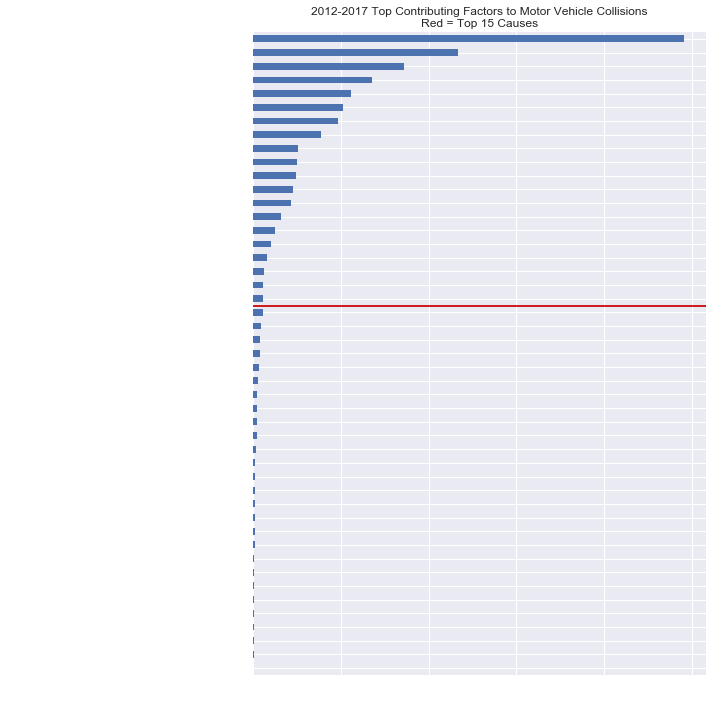

In [12]:
def plot_top_causes(data):
    d = data[(data['year']<=2015) | ((data['month'] <=3) & (data['year']==2016))]
    d = d.groupby('reason').agg({'incidents': np.sum}).sort_values(by='incidents')
    d.plot(kind='barh', legend=False, figsize=(10,10))
    plt.title('2012-2017 Top Contributing Factors to Motor Vehicle Collisions\nRed = Top 15 Causes')
    plt.xlabel('Incidents')
    plt.ylabel('')
    plt.axhline(len(d)-20.5, color='#CC0000')
    plt.tight_layout()
    plt.savefig('nypd_largest_reasons.jpg', dpi=80)

plot_top_causes(results_nypd)

## Combining Data
We need to do a few steps here. First we group daily observations by station. Once aggregated, we take the median value of all the stations as the true NOAA weather value. For the NYPD incident data, we aggregate values to the top 20 largest

In [13]:
def combine_data(data_noaa, data_nypd):
    
    # Prepare NOAA data
    cols = ['date','day','year','month','dow','id']
    
    d_prcp = data_noaa[data_noaa['element'] == 'PRCP'].groupby(cols).agg({'value': np.sum}).reset_index().rename(columns={'value': 'PRCP'})
    d_tmax = data_noaa[data_noaa['element'] == 'TMAX'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'TMAX'})
    d_tmin = data_noaa[data_noaa['element'] == 'TMIN'].groupby(cols).agg({'value': np.min}).reset_index().rename(columns={'value': 'TMIN'})
    d_snwd = data_noaa[data_noaa['element'] == 'SNWD'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'SNWD'})
        
    d_noaa = d_prcp.merge(d_tmax, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_tmin, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_snwd, on=cols, how='outer')
    
    d_noaa = d_noaa.groupby(['date','day','year','month','dow']).agg(np.median).reset_index().fillna(0)
    d_noaa['TMAX'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    d_noaa['TMIN'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    
    # Prepare NYPD data, use top 20 reasons from prior to April 2016
    d_prior = data_nypd[(data_nypd['year']<=2015) | ((data_nypd['month'] <=3) & (data_nypd['year']==2016))]
    top_reasons = d_prior.groupby('reason').agg({'incidents': np.sum}).nlargest(20, columns='incidents').index.values
    
    d_nypd = data_nypd.copy()
    d_nypd['reason'] = d_nypd['reason'].apply(lambda x: 'Other' if x not in top_reasons else x)
    
    d_nypd = d_nypd.pivot_table(index=['day','year','month','dow'], 
                                columns='reason', values='incidents', aggfunc='sum').replace(0, np.NaN)
    d_nypd['Total'] = d_nypd.sum(axis=1)
    
    # Merge Results
    d_combined = d_nypd.reset_index().merge(d_noaa, on=['day','year','month','dow'], how='inner')
    d_combined['IsWeekend'] = d_combined['dow'].isin([1,7]).astype(int)

    return d_combined

pvt_combined = combine_data(results_noaa, results_nypd)
pvt_combined.head(5)

,day,year,month,dow,Aggressive Driving/Road Rage,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,...,Traffic Control Disregarded,Turning Improperly,View Obstructed/Limited,Total,date,PRCP,TMAX,TMIN,SNWD,IsWeekend
0,1,2012,7,1,NaN,8.0,21.0,62.0,7.0,16.0,...,8.0,11.0,1.0,233.0,2012-07-01,0.0,95.00,49.1000,0.0,1
1,1,2012,8,4,2.0,3.0,15.0,57.0,10.0,27.0,...,9.0,13.0,1.0,254.0,2012-08-01,81.0,81.05,46.5890,0.0,0
2,1,2012,9,7,1.0,6.0,12.0,52.0,7.0,20.0,...,10.0,9.0,1.0,222.0,2012-09-01,0.0,90.05,48.2090,0.0,1
3,1,2012,10,2,4.0,1.0,9.0,69.0,9.0,18.0,...,5.0,14.0,1.0,230.0,2012-10-01,0.0,71.51,44.8718,0.0,0
4,1,2012,11,5,2.0,3.0,12.0,48.0,2.0,17.0,...,4.0,9.0,NaN,186.0,2012-11-01,0.0,51.98,41.3564,0.0,0


## Data Quality Check
A basic timeseries plot reveals a problem with the NYPD traffic data. We have quite a large gap starting around April 2016. This data is present in the original BQ data and is not due to our join on NOAA. The next set of charts show this gap is consistently present. Also some types disappear while others appear. Others seem to shift their reporting rates.

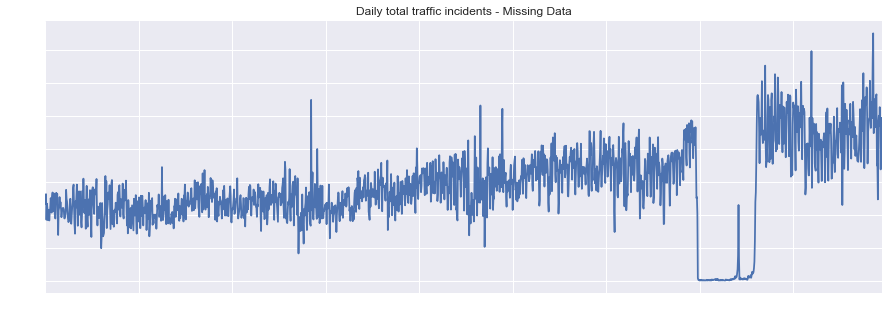

In [14]:
%matplotlib inline

pvt_combined.sort_values(by='date').set_index('date')['Total'].plot(figsize=(15,5))
plt.title('Daily total traffic incidents - Missing Data')
plt.ylabel('Total Incidents');
plt.savefig('nypd_daily_records.jpg', dpi=80)

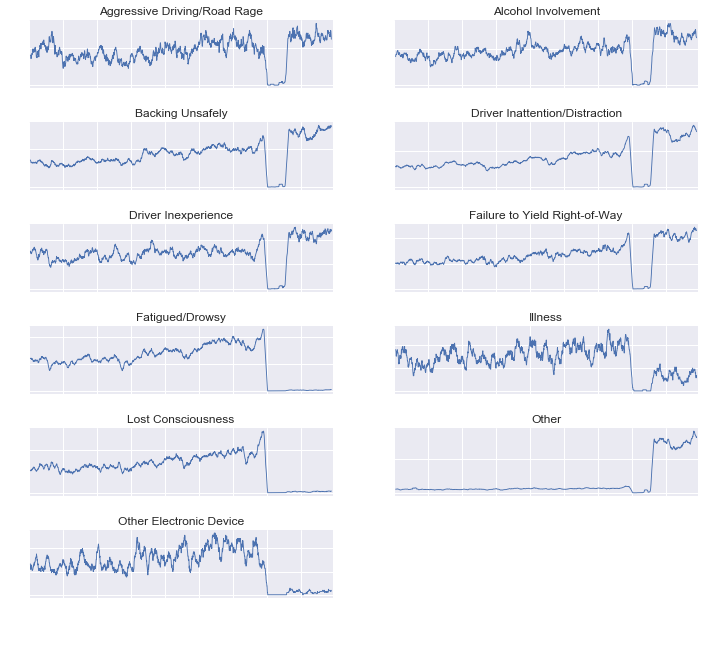

In [15]:
def plot_types(data):
    d = data[[c for c in data.columns if c not in ['day','year','month','dow','PRCP','IsWeekend',
                                                   'TMAX','TMIN','SNWD']]]
    d = d.sort_values(by='date').set_index('date').fillna(0)
    #d = d.apply(lambda x: x.rolling(center=True, window=5))
    d = d.rolling(window=21, center=True, axis=0).mean()

    fig = plt.figure(figsize=(12,20))
    l = math.ceil(len(d.columns)/2)
    for i in range(0, l):
        ax = plt.subplot(l, 2, i+1)
        d.iloc[:,i].plot(ax=ax, linewidth=0.9)
        ax.set_title(d.columns[i])
        ax.set_xlabel('')
        if i < l-2:
            ax.tick_params(labelbottom='off')
        else:
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

            
    
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_all.jpg', dpi=80)
    
plot_types(pvt_combined)


## Fix data the easy way
Due to the scale changes and missing statuses, just going to take a safter approach and look at data prior to April 2016

In [21]:
def fix_data(data):
    # Assume data before April 2016 is safe for use
    d = data[(data['date']<'2016-04-01')]
    return d

pvt_fixed = fix_data(pvt_combined)
pvt_fixed.head()

,day,year,month,dow,Aggressive Driving/Road Rage,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,...,Traffic Control Disregarded,Turning Improperly,View Obstructed/Limited,Total,date,PRCP,TMAX,TMIN,SNWD,IsWeekend
0,1,2012,7,1,NaN,8.0,21.0,62.0,7.0,16.0,...,8.0,11.0,1.0,233.0,2012-07-01,0.0,95.00,49.1000,0.0,1
1,1,2012,8,4,2.0,3.0,15.0,57.0,10.0,27.0,...,9.0,13.0,1.0,254.0,2012-08-01,81.0,81.05,46.5890,0.0,0
2,1,2012,9,7,1.0,6.0,12.0,52.0,7.0,20.0,...,10.0,9.0,1.0,222.0,2012-09-01,0.0,90.05,48.2090,0.0,1
3,1,2012,10,2,4.0,1.0,9.0,69.0,9.0,18.0,...,5.0,14.0,1.0,230.0,2012-10-01,0.0,71.51,44.8718,0.0,0
4,1,2012,11,5,2.0,3.0,12.0,48.0,2.0,17.0,...,4.0,9.0,NaN,186.0,2012-11-01,0.0,51.98,41.3564,0.0,0


## 

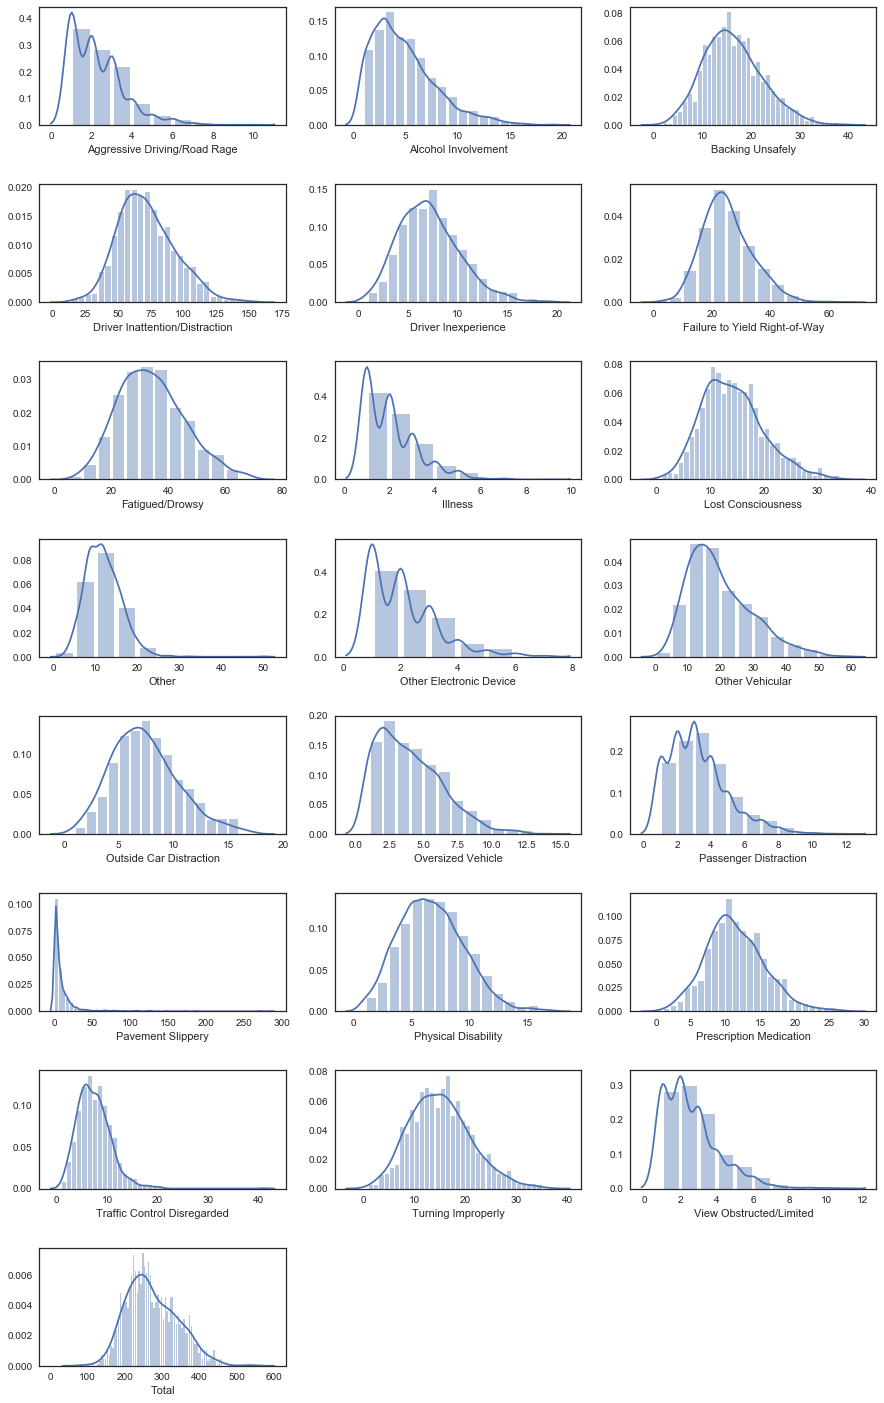

In [22]:
def plot_distributions(data):
    %matplotlib inline
    ds = data[[c for c in data.columns if c not in ['day','year','month','dow','date','TMAX','TMIN','SNWD','PRCP','IsWeekend']]]
    c = 3
    r = math.ceil(len(ds.columns) / c)
    
    sns.set_style('white')
    plt.figure(figsize=(15,25))
    for i in range(0, len(ds.columns)):
        ax = plt.subplot(r, c, i+1)
        d = ds.iloc[:, i].dropna()
        m = int(d.max())

        bins = list(range(0, m, 1 if m<50 else 5))
        sns.distplot(d, ax=ax, bins=bins, hist_kws={'rwidth': 0.8})
        
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_dist.jpg', dpi=80)
    
plot_distributions(pvt_fixed)

## Show correlations against precip, snow depth, temperature, and is weekend
Use the seaborn clustering heatmap to show the acceident types correlated against the 4 independent variables. The rows are clustered using a cosine distance. Meaning rows which have similar column values will be grouped together.


C:\Users\jbenc\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


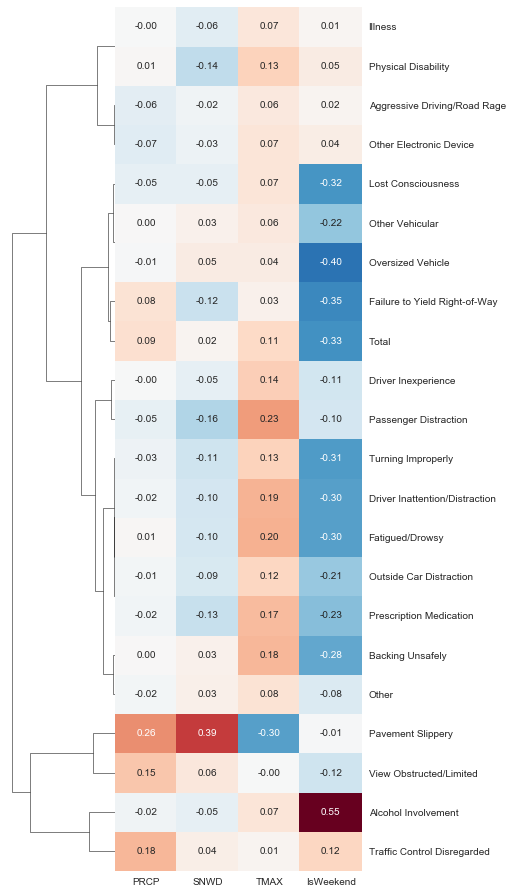

In [23]:
def plot_corr(data):
    # Columns for the heatmap
    cols = ['PRCP','SNWD','TMAX', 'IsWeekend']
    
    d= data[[c for c in data if c not in ['day','year','month','dow','TMIN']]].corr()
    d = d.loc[~d.index.isin(cols), cols] # Prevent creating a triangle effect
    
    %matplotlib inline
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    cm = sns.clustermap(d, col_cluster=False, metric='cosine', method='complete', annot=True, fmt='.2f', figsize=(5,20))
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # Some formatting to remove the column dendograms which take up space regardless. Also format the row dendograms
    cm.cax.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    hm = cm.ax_heatmap.get_position()
    cm.ax_heatmap.set_position([.3, .5, hm.width, hm.height])
    cm.ax_row_dendrogram.set_position([0, .5, .3, hm.height])
    plt.savefig('nypd_daily_records_cormap.jpg', dpi=120)
    plt.show()
    
plot_corr(pvt_fixed)

## Plot accident frequency relative to other accident types

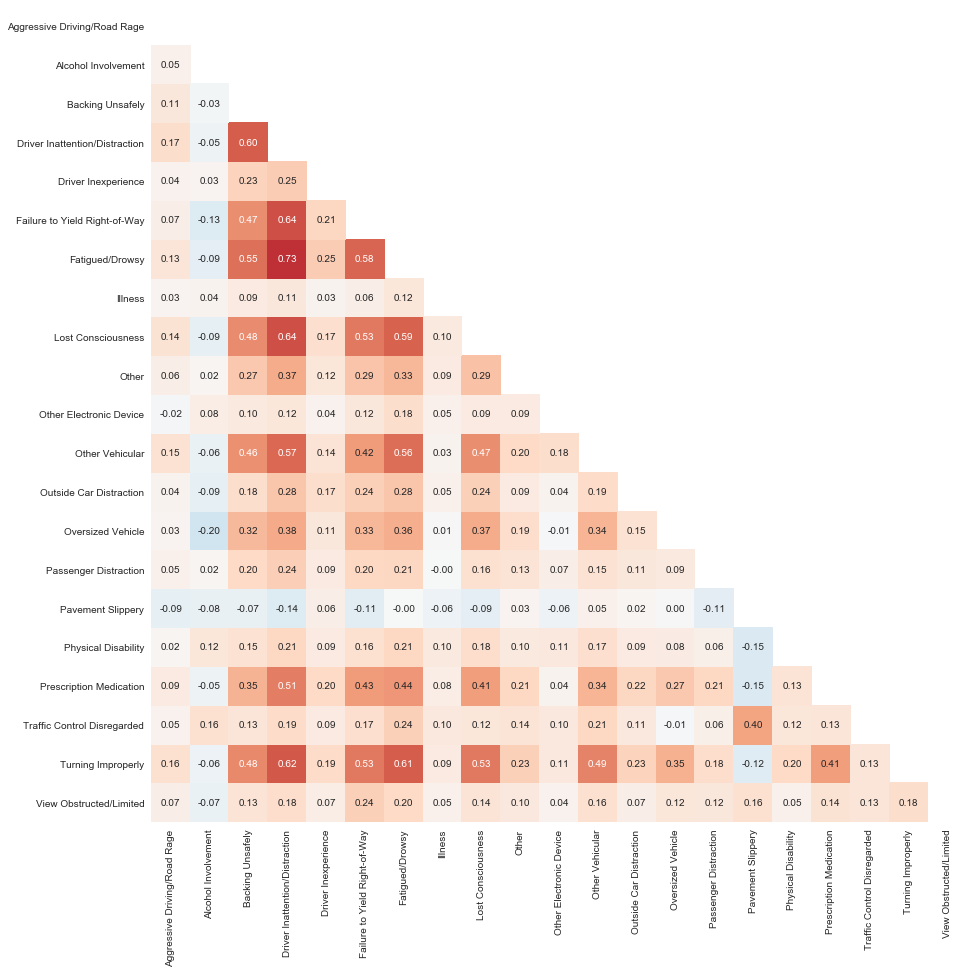

In [24]:
def plot_corr_accident(data):
    d = data[[c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','PRCP','SNWD','Total','IsWeekend']]].corr()
    
    mask = np.zeros_like(d)
    mask[np.triu_indices_from(mask)] = True
    
    %matplotlib inline
    plt.figure(figsize=(15,15))
    with sns.axes_style("white"):
        sns.heatmap(d, cbar=False, square=True, annot=True, fmt='.2f', mask=mask)
        
    plt.savefig('nypd_traffic_corr.jpg', dpi=80)
    
plot_corr_accident(pvt_fixed)
    

# Perform Linear Regression
For each accident type, run a linear regression model to see the impact of temperature, rain, snow, and weekends against the total reported accidents. The following charts highlight significant vairables in green (p <= 0.05)

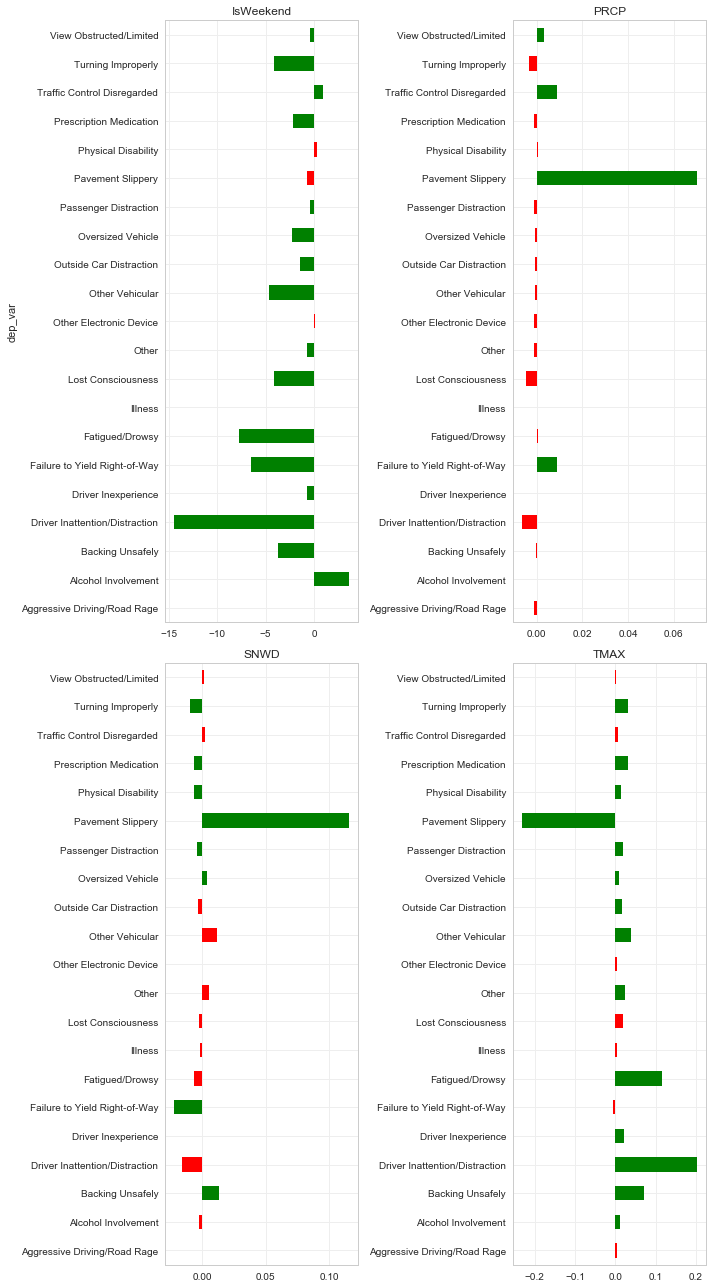

In [25]:
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn import preprocessing

def plot_regressors(data):
    d = data.copy()
    d['IsWeekend'] = d['dow'].isin([1,7]).astype(int)

    X_cols = ['TMAX','SNWD','PRCP','IsWeekend']
    y_cols = [c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','SNWD','PRCP','Total','date','IsWeekend']]
    
    out = pd.DataFrame()
    for c in y_cols:
        d_filtered = d[~d[c].isnull()]
        X = d_filtered[X_cols]
        X = sm.add_constant(X)
        
        y = d_filtered[c]
        model = OLS(y, X)
        result = model.fit()
        r = result.conf_int()
        r['pa'] = result.params
        r['pv'] = result.pvalues
        r['name'] = c
        
        out = pd.concat([out, r])
        
    out = out.reset_index()   
    out.columns = ['ind_var','cl_lower','cl_upper','coef','pvalue','dep_var']
    out = out[out['ind_var']!='const']
    
    %matplotlib inline
    sns.set_style('whitegrid', {'grid.color': '#EEEEEE'})
    sns.despine()
    plt.figure(figsize=(10,18))
    i=1
    for name, group in out.groupby('ind_var'):
        ax = plt.subplot(2, 2, i)
        c = (group['pvalue']<0.01).map({True: 'green', False: 'red'})
        group.plot(x='dep_var', y='coef', kind='barh', ax=ax, title=name, legend=False, color=c)
        
        if i>1:
            1==1
            #ax.set_yticklabels([])
            #ax.yaxis.set_visible(False)
            ax.set_ylabel('')
        i += 1
    plt.subplots_adjust(wspace=0.9)
    plt.tight_layout()
    plt.savefig('nypd_traffic_reg.jpg', dpi=120)
    return out


reg = plot_regressors(pvt_fixed)
    

## Plot day of week heatmap

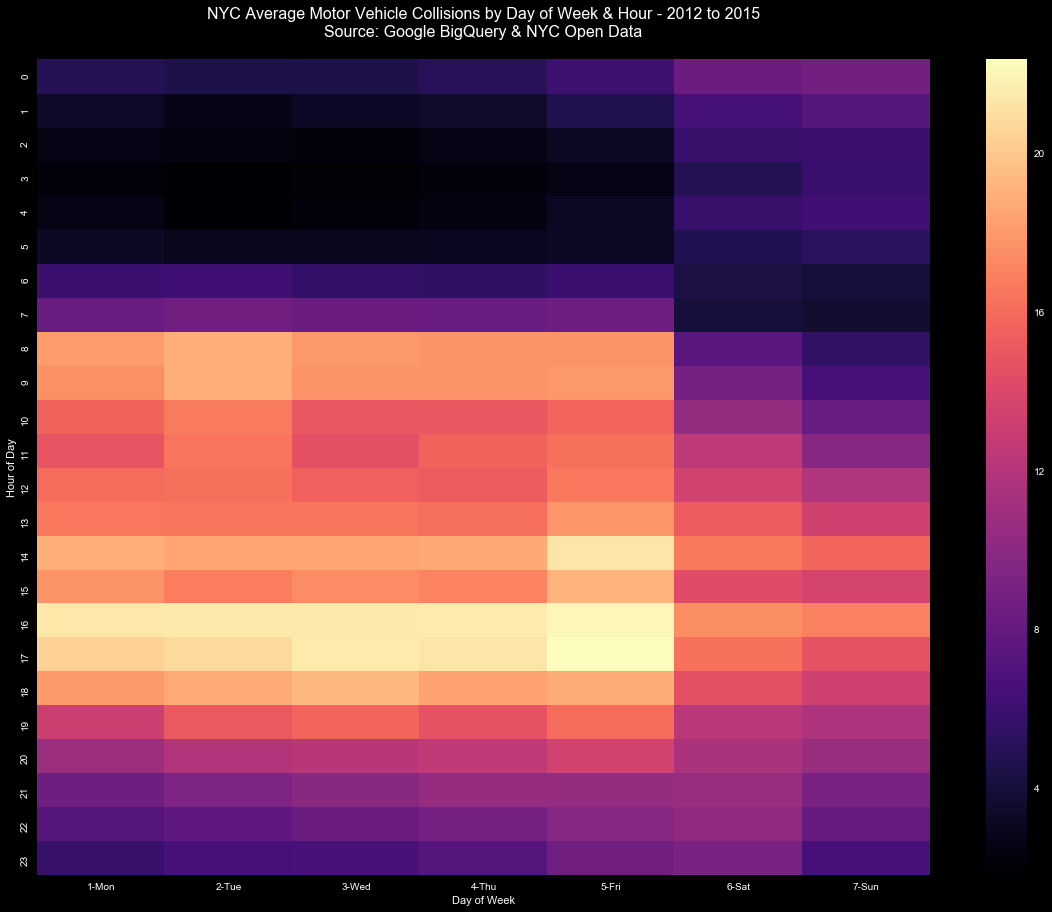

In [11]:
def plot_heatmap(data):
    d = data.copy()
    d['dow'] = d['dow'].map({1: '7-Sun', 2: '1-Mon', 3: '2-Tue', 4:'3-Wed', 5:'4-Thu', 6:'5-Fri', 7:'6-Sat'})
    d['avg'] = d['incidents'] / d['days']
    d = d.pivot(index='hour', columns='dow', values='avg')

    %matplotlib inline

    custom_style = {
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white'}
    sns.set_style("darkgrid", rc=custom_style)
    fig = plt.figure(figsize=(20,15), facecolor='black')
    sns.heatmap(d, cmap='magma', cbar=True)
    
    plt.title('NYC Average Motor Vehicle Collisions by Day of Week & Hour - 2012 to 2015\nSource: Google BigQuery & NYC Open Data\n', color='white', fontsize=16)
    plt.xlabel("Day of Week")
    plt.ylabel("Hour of Day")
    plt.savefig('nypd-heatmap-out.png', facecolor=fig.get_facecolor(), transparent=True)
    
plot_heatmap(results_nypd2)  